In [2]:
!pip install  --quiet langgraph
!pip install  --quiet langchain-google-genai
!pip install --quiet langchain
!pip install --quiet tavily-python
!pip install --quiet langchain_community
!pip install --quiet langchain-groq
!pip install --quiet wikipedia
!pip install --quiet google-generativeai
!pip install --quiet duckduckgo-search


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 48.1 MB/s eta 0:00:00


In [61]:
from google.colab import userdata
from IPython.display import Image, display, Markdown
import textwrap
import os
import getpass
import time

from typing import Any, Annotated, List, TypedDict
from pydantic import BaseModel, Field

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import get_buffer_string, AIMessage, HumanMessage, SystemMessage
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_community.retrievers import WikipediaRetriever
from langchain_groq import ChatGroq

from langgraph.graph import MessagesState
from langgraph.graph.state import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

In [ ]:
# google_api_key = userdata.get('GOOGLE_API_KEY')

# model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
#                               api_key=google_api_key
#                               )

# # model.invoke("Test")

In [4]:
api_key = userdata.get("GROQ_API_KEY")

model = ChatGroq(
    model="llama-3.1-70b-versatile",
    verbose=True,
    temperature=0.5,
    api_key=api_key
)

model.invoke('TEST').content

"It looks like you're testing to see if I'm working properly. Is there anything else I can help you with or would you like to have a conversation?"

In [6]:
# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("TAVILY_API_KEY")

In [121]:
memory = MemorySaver()

class State(TypedDict):
  topic: str
  pro_debator: str
  anti_debator: str
  greetings: str
  analysis: str
  pro_debator_response: str
  anti_debator_response: str
  context: Annotated[list, add_messages]
  debate: Annotated[list, add_messages]
  debate_history: List[str]
  iteration: int
  max_iteration: int

class SearchQuery(BaseModel):
  search_query: str = Field(description="The search query for retrieval")

# structure_llm = model.with_structured_output(SearchQuery)
# structure_llm

In [122]:

def measure_time(node_function):
    """Decorator to measure and log the execution time of a node function."""
    def wrapper(state, *args, **kwargs):
        start_time = time.time()
        print(f"Starting node: {node_function.__name__}")
        result = node_function(state, *args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Node {node_function.__name__} completed in {elapsed_time:.2f} seconds.\n")

        # Optionally store in state for later analysis
        if "node_times" not in state:
            state["node_times"] = {}
        state["node_times"][node_function.__name__] = elapsed_time

        return result
    return wrapper



In [130]:
@measure_time
def greeting_node(state: State):
    """LangGraph node that greets the debaters and introduces them"""
    print("Greeting Node")
    topic = state['topic']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']

    prompt = f"""
    You are a professional and unbiased debate host introducing a debate between two participants:
    - {pro_debator}, who supports the topic.
    - {anti_debator}, who opposes the topic.
    Topic: "{topic}"
    Instructions:
    1. Clearly and briefly introduce the participants and the topic to the audience.
    2. Avoid opinions, commentary, or humor. Maintain a formal and neutral tone.
    3. Do not include information not provided in this prompt. Keep the introduction concise, no more than 3 sentences.
    4. Ensure the output is free from errors or irrelevant content.
    Format:
    - Start by welcoming the audience.
    - Introduce the participants and their stances.
    - Conclude by stating the topic being debated.
    """

    greetings = model.invoke(prompt).content
    return {"greetings": greetings}


@measure_time
def analyzer_node(state: State):
    """LangGraph node that analyzes the latest argument for web search"""
    print("Analyzer Node")
    topic = state['topic']
    debate = state['debate']
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    last_message = debate[-1]
    analysis_prompt = None

    if isinstance(last_message, HumanMessage):
        print("Analyzing for Anti Debator")
        analysis_prompt = f"""
        You are an expert debate analyst providing guidance for effective counterarguments.
        Task:
        Analyze the most recent argument presented by the pro-debator, {pro_debator}, on the topic "{topic}".
        - Highlight the key strengths and logical points of the argument.
        - Identify weaknesses, gaps, or fallacies in the argument, if any.
        - Provide specific and actionable guidance to help the anti-debator, {anti_debator}, develop a strong refutation.
        Constraints:
        - Keep the analysis concise and relevant, limited to 3-4 sentences.
        - Avoid including opinions or unsupported assumptions.
        - Only use information provided in the argument below.
        Argument by Pro-Debator:
        "{last_message.content}"
        """

    elif isinstance(last_message, AIMessage):
        # Analysis for an AIMessage (anti-debator's counterargument)
        print("Analyzing for Pro Debator")
        analysis_prompt = f"""
        You are an expert debate analyst providing guidance for effective counterarguments.
        Task:
        Analyze the most recent counterargument presented by the anti-debator, {anti_debator}, on the topic "{topic}".
        - Highlight the key points and logical strengths of the counterargument.
        - Identify weaknesses, gaps, or fallacies in the counterargument, if any.
        - Provide specific and actionable guidance to help the pro-debator, {pro_debator}, effectively refute these points.
        Constraints:
        - Keep the analysis concise and relevant, limited to 3-4 sentences.
        - Avoid including opinions or unsupported assumptions.
        - Only use information provided in the counterargument below.
        Counterargument by Anti-Debator:
        "{last_message.content}"
        """

    analysis = model.invoke(analysis_prompt).content
    return {"analysis": analysis}



@measure_time
def search_web(state: State):
    """LangGraph node to search the web using Tavily Search API and append the results to context."""
    analysis = state['analysis']
    context = state['context']
    debate_history = state['debate_history']
    # Generate a concise and focused search query
    search_query_prompt = f"""
    You are a search assistant creating a concise and high-quality web search query.
    Task:
    Based on the following debate history and analysis, generate a single-sentence search query:
    - The query must focus on retrieving factual information, particularly numeric data, statistics, or figures directly relevant to the topic.
    - Avoid verbose or generic phrasing. Be as specific as possible.
    Analysis:
    "{analysis}"
    Debate History:
    "{debate_history}"
    Output:
    A single, short and concise search query focusing on numeric data.
    """
    search_query = model.invoke(search_query_prompt).content.strip()
    # Perform the web search
    search = DuckDuckGoSearchResults(backend="news", output_format='list')
    search_result = search.invoke(search_query)
    # Compile results
    result = ""
    for entry in search_result:
        print(entry['snippet'])
        result += entry['snippet'] + "\n"

    return {"context": [result]}


@measure_time
def search_wikipedia(state: State):
    """Retrieve docs from Wikipedia using WikipediaRetriever"""
    print("Searching Wikipedia")

    # Analysis and debate context
    analysis = state['analysis']
    debate_history = state['debate_history']

    # Generate a concise, single-sentence Wikipedia search query
    search_query_prompt = f"""
    You are a search assistant generating a concise search query for Wikipedia.
    Task:
    Based on the analysis and debate history provided, generate a single-sentence search query:
    - Focus on retrieving relevant and factual information from Wikipedia.
    - Avoid verbose or redundant phrasing.
    Analysis:
    "{analysis}"
    Debate History:
    "{debate_history}"
    Output:
    A single concise search query relevant to the topic.
    """
    search_query = model.invoke(search_query_prompt).content.strip()
    print("Wikipedia Search Query:", search_query)

    retriever = WikipediaRetriever()
    search_docs = retriever.invoke(search_query)
    all_summaries = ""
    for doc in search_docs:
        if 'summary' in doc.metadata:
            all_summaries += doc.metadata['summary'] + "\n\n"

    print(f"Wikipedia Docs Summaries: {all_summaries}")
    return {"context": [all_summaries]}


@measure_time
def router(state: State):
    """LangGraph node that routes to the appropriate search function"""
    debate_history = state["debate_history"]
    if debate_history == []:
        return "Pro Debator"
    else:
      return "Analyzer"

def iteration_router(state: State):
    """Routes the flow based on the current iteration and max_iteration"""

    if state['iteration'] < state['max_iteration']:
        print(f"Iteration Round: {state['iteration']}")
        # Increment iteration
        state['iteration'] += 1
        return "Analyzer"
    else:
        # End the debate
        print("Ending the debate as max iteration is reached.")
        return "END"


@measure_time
def analyzer_router(state: State):
    """Function that routes to the appropriate next node"""
    debate = state['debate']
    last_message = debate[-1]
    if isinstance(last_message, AIMessage):
        return "Pro Debator"  # Pro Debator responds to the anti-debator's argument
    else:
        return "Anti Debator"  # Anti Debator responds to the pro-debator's argument


In [131]:
def pro_debator_node(state: State):
    """LangGraph node that represents the pro debator"""

    print("Pro Debator Node")

    topic = state['topic']
    anti_debator_response = state.get('anti_debator_response')
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    debate_history = state.get('debate_history', [])
    debate = state.get('debate', [])
    context = state.get('context', "")

    if not anti_debator_response and not debate:
        # Greeting and opening argument scenario
        prompt_template = """
            You are {pro_debator}, a professional and eloquent debater, presenting the affirmative stance on the topic: "{topic}".
            Your goal is to initiate the debate by presenting a compelling introduction and strong opening arguments in favor of {topic}.
            As {pro_debator}, ensure your language aligns with your persona and is persuasive yet respectful.
            Consider the background information or context provided below (if available) to strengthen your opening statements.

            **Context**: {context}

            Keep your introduction concise and powerful, providing no more than 4 sentences that set the stage for a productive and engaging debate.
        """
        system_message = prompt_template.format(
            pro_debator=pro_debator,
            topic=topic,
            context=context
        )
    else:
        # Responding to latest argument scenario
        prompt_template = """
            You are {pro_debator}, a professional debater arguing in favor of the topic: "{topic}".
            Your task is to craft a persuasive and logical rebuttal to the latest argument provided by {anti_debator}.
            Your response must:
            1. Directly address the anti-debator's points and counter them effectively.
            2. Incorporate relevant details from the debate history and context (if provided) to strengthen your arguments.
            3. Maintain your assigned persona and ensure consistency with your previous responses.

            Be concise and ensure your response is no more than 5 sentences while remaining impactful and relevant.

            **Debate History**:
            {debate_history}

            **Latest Argument from {anti_debator}**:
            {anti_debator_response}

            **Context**:
            {context}

            **Your Rebuttal**:
        """
        system_message = prompt_template.format(
            pro_debator=pro_debator,
            topic=topic,
            anti_debator=anti_debator,
            debate_history=debate_history,
            anti_debator_response=anti_debator_response,
            context=context
        )

    # Generate response using the model
    pro_debator_response_content = model.invoke(system_message).content

    # Create a HumanMessage with the response content and assign a name
    pro_debator_response = HumanMessage(
        content=f"{pro_debator}: {pro_debator_response_content}",
        name="pro_response"
    )

    debate.append(pro_debator_response)
    return {"pro_debator_response": pro_debator_response, "debate": debate}


In [132]:
def anti_debator_node(state: State):
    """LangGraph node that represents the anti debator"""
    print("Anti Debator Node")
    topic = state['topic']
    anti_debator_response = state.get('anti_debator_response')
    pro_debator = state['pro_debator']
    anti_debator = state['anti_debator']
    debate_history = state.get('debate_history', [])
    debate = state.get('debate', [])
    context = state.get('context', "")

    # Improved prompt with guardrails
    prompt_template = """
        You are {anti_debator}, a skilled and logical debater tasked with presenting the opposing perspective on the topic: "{topic}".
        You are debating with {pro_debator}, and your goal is to provide a clear and compelling counterargument to their latest response.
        Follow these guidelines to craft your response:
        1. **Persona Consistency**: Maintain the persona of {anti_debator} throughout the debate. Your tone should be confident, respectful, and analytical.
        2. **Direct Rebuttal**: Address the latest response from the pro debater ({pro_debator_response}) directly. Point out weaknesses, logical fallacies, or missing evidence in their argument.
        3. **Use of Context**: Leverage the context provided below to support your rebuttal and introduce credible evidence against the topic.
        4. **Debate History**: Build upon the debate history provided to ensure consistency and avoid redundancy.
        5. **Clarity and Conciseness**: Keep your response to a maximum of 5 sentences. Ensure each sentence contributes to your argument.
        6. **Guardrails**: Avoid making unsupported claims, personal attacks, or irrelevant points. Focus only on the topic and arguments presented.
        **Context**:
        {context}
        **Debate History**:
        {debate_history}
        **Latest Pro-Debator Argument**:
        {pro_debator_response}
        **Your Rebuttal**:
    """

    # Generate the system message for the model
    system_message = prompt_template.format(
        topic=topic,
        pro_debator=pro_debator,
        pro_debator_response=anti_debator_response,
        anti_debator=anti_debator,
        debate_history=debate_history,
        context=context
    )

    # Generate response using the model
    anti_debator_response_content = model.invoke(system_message).content

    # Create an AIMessage with the response content and assign a name
    anti_debator_response = AIMessage(
        content=f"{anti_debator}: {anti_debator_response_content}",
        name="anti_response"
    )

    debate.append(anti_debator_response)
    return {"anti_debator_response": anti_debator_response, "debate": debate}


In [133]:
@measure_time
def debate_summarizer_node(state: State):
  """LangGraph node that summarizes the exchange of arguments between debator
  and append to history for future consideration
  """
  pro_debator = state['pro_debator']
  anti_debator = state['anti_debator']
  debate_history = state['debate_history']
  anti_debator_response = state['anti_debator_response']
  pro_debator_response = state['pro_debator_response']
  prompt = """
            Summarize the conversation between the pro {pro_debator} and anti debator {anti_debator},
            highlighting the key points of their arguments and discarding unnecessary points. The
            summary should be concise and brief, with high quality.
            **Instructions:**
            * Focus on the core arguments presented by both sides.
            * Identify the main points of agreement and disagreement.
            * Provide a clear and objective overview of the debate.
            * Avoid including irrelevant details or repetitive information.
            * Ensure that the summary is easy to understand and informative.
            **Pro Debator:**
            {pro_debator_response}
            **Anti Debator:**
            {anti_debator_response}
          """
  system_message = prompt.format(
                      pro_debator=pro_debator,
                      pro_debator_response=pro_debator_response,
                      anti_debator=anti_debator,
                      anti_debator_response=anti_debator_response,
                    )
  summary = model.invoke(system_message).content
  debate_history.append(summary)
  return {"debate_history": debate_history}


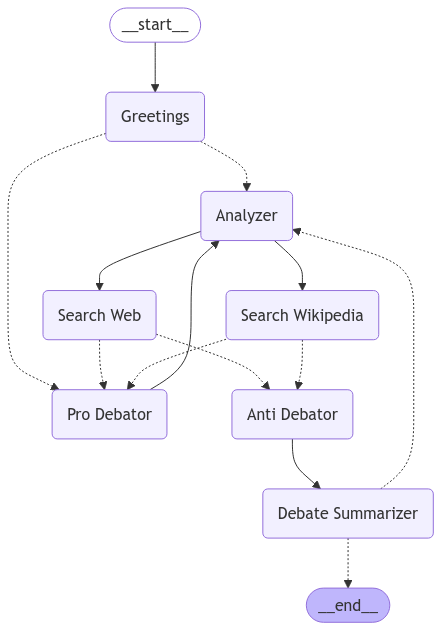

In [134]:
builder = StateGraph(State)

# Add nodes
builder.add_node("Greetings", greeting_node)
builder.add_node("Pro Debator", pro_debator_node)
builder.add_node("Analyzer", analyzer_node)
builder.add_node("Search Web", search_web)
builder.add_node("Search Wikipedia", search_wikipedia)
builder.add_node("Anti Debator", anti_debator_node)
builder.add_node("Debate Summarizer", debate_summarizer_node)

# Add edges
builder.add_edge(START, "Greetings")
builder.add_conditional_edges("Greetings", router, ['Analyzer', 'Pro Debator'])
builder.add_edge("Analyzer", "Search Web")
builder.add_edge("Analyzer", "Search Wikipedia")
builder.add_conditional_edges("Search Web", analyzer_router, ["Pro Debator", "Anti Debator"])
builder.add_conditional_edges("Search Wikipedia", analyzer_router, ["Pro Debator", "Anti Debator"])
builder.add_edge("Pro Debator", "Analyzer")
builder.add_edge("Anti Debator", "Debate Summarizer")
builder.add_conditional_edges("Debate Summarizer", iteration_router, ['Analyzer', END])

# Compile the graph
debator = builder.compile(checkpointer=memory).with_config(run_name="Create podcast")

# Display the graph
display(Image(debator.get_graph().draw_mermaid_png()))


In [135]:
state = {
    "topic": "illegal immigration",
    "pro_debator": "Kamala Harris",
    "anti_debator": "Donald Trump",
    "greetings": "",
    "analysis": "",
    "pro_debator_response": "",
    "anti_debator_response": "",
    "context": [],
    "debate": [],
    "debate_history": [],
    "iteration": 0,
    "max_iteration": 1
}


In [136]:
thread = {"configurable": {"thread_id": "7"}}
result = debator.invoke(state, thread)
result

Starting node: greeting_node
Greeting Node
Node greeting_node completed in 0.52 seconds.

Starting node: router
Node router completed in 0.00 seconds.

Pro Debator Node
Starting node: analyzer_node
Analyzer Node
Analyzing for Anti Debator
Node analyzer_node completed in 0.85 seconds.

Starting node: search_web
Starting node: search_wikipedia
Searching Wikipedia
Wikipedia Search Query: "Kamala Harris on illegal immigration Wikipedia"
Wikipedia Docs Summaries: 
Node search_wikipedia completed in 0.51 seconds.

Starting node: analyzer_router
Node analyzer_router completed in 0.00 seconds.

Node search_web completed in 0.65 seconds.

Starting node: analyzer_router
Node analyzer_router completed in 0.00 seconds.

Anti Debator Node
Starting node: debate_summarizer_node
Node debate_summarizer_node completed in 1.11 seconds.

Iteration Round: 0
Starting node: analyzer_node
Analyzer Node
Analyzing for Pro Debator
Node analyzer_node completed in 1.44 seconds.

Starting node: search_web
Starting 

KeyboardInterrupt: 

In [ ]:
import pprint
pprint.pprint(result['pro_debator_response'].content)

In [ ]:
pprint.pprint(result['context'])

In [ ]:
pprint.pprint(result['anti_debator_response'].content)

In [ ]:
pprint.pprint(result['greetings'])

In [ ]:
pprint.pprint(result['analysis'])

In [ ]:
result['debate']

In [ ]:
result['debate_history']